In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import butter, filtfilt, spectrogram, iirnotch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import butter, filtfilt, spectrogram, iirnotch
import glob
import os
import sys
from scipy import signal
import matplotlib.pyplot as plt
from multiprocessing import Pool

import mne
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from mne.io import concatenate_raws
from mne.io import concatenate_raws
from mne import Epochs, pick_types, events_from_annotations
from mne.preprocessing import create_ecg_epochs, create_eog_epochs, ICA
from mne.channels import read_layout

In [2]:
ch_names = ["AFz", "Fz", "Fp1", "Fp2", "AF7", "AF5", "AF3", "AF4", "AF6", "AF8", "F7", 
            "F5", "F3", "F1", "F2", "F4", "F6", "F8", "FT7", "FC5", "FC3", "FC1", "FCz", 
            "FC2", "FC4", "FC6", "FT8", "T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", 
            "T8","TP7", "CP5", "CP3", "CP1", "CPz", "CP2", "CP4", "CP6", "TP8", "P7", 
            "P5", "P3", "P1", "Pz", "P2", "P4", "P6", "P8", "PO7", "PO3", "POz", "PO4", 
            "PO8", "O1", "Oz", "O2"]
ch_eogs = ["VEOG", "HEOG"]
ch_names_all = ch_names+ch_eogs
smp_freq = 1200
print(len(ch_names))
X_import = pd.read_csv("s003_gtec_midi_01_093.csv",  names=["Timestamps"]+ch_names+["unknown", "reference"]+ch_eogs)
X_import.head() 

62


,Timestamps,AFz,Fz,Fp1,Fp2,AF7,AF5,AF3,AF4,AF6,...,POz,PO4,PO8,O1,Oz,O2,unknown,reference,VEOG,HEOG
0,50.42,-6408.039062,-6907.152344,-5600.601562,-15854.556641,-4335.697266,-2611.787109,-7649.470703,-8548.460938,-7465.613281,...,-7133.484375,-7786.714844,-7117.433594,-10126.578125,-6094.535156,-5186.720703,279997.93750,33142.859375,-149559.906250,-156589.781250
1,50.42,-6407.787109,-6909.833984,-5599.623047,-15854.796875,-4334.873047,-2609.462891,-7647.539062,-8551.843750,-7470.517578,...,-7133.843750,-7786.759766,-7117.621094,-10126.001953,-6095.205078,-5187.509766,280498.34375,32641.548828,-149545.875000,-156580.453125
2,50.42,-6396.289062,-6898.857422,-5589.984375,-15845.151367,-4326.080078,-2599.931641,-7638.208984,-8539.832031,-7460.511719,...,-7127.998047,-7779.949219,-7111.785156,-10120.894531,-6090.734375,-5182.833984,280966.53125,32174.087891,-149525.500000,-156572.328125
3,50.42,-6381.462891,-6882.578125,-5577.310547,-15828.474609,-4311.898438,-2586.759766,-7625.800781,-8523.623047,-7444.230469,...,-7117.802734,-7770.707031,-7103.730469,-10111.365234,-6082.470703,-5173.341797,281407.06250,31732.171875,-149498.406250,-156565.250000
4,50.42,-6382.953125,-6886.019531,-5578.166016,-15831.599609,-4311.750000,-2586.005859,-7627.158203,-8529.597656,-7450.166016,...,-7116.716797,-7769.941406,-7103.988281,-10109.134766,-6080.943359,-5170.466797,281804.56250,31334.859375,-149479.390625,-156562.937500


In [3]:
X_after_drop = X_import.drop(columns=["Timestamps", "unknown", "reference"])
X_after_drop.head()

,AFz,Fz,Fp1,Fp2,AF7,AF5,AF3,AF4,AF6,AF8,...,PO7,PO3,POz,PO4,PO8,O1,Oz,O2,VEOG,HEOG
0,-6408.039062,-6907.152344,-5600.601562,-15854.556641,-4335.697266,-2611.787109,-7649.470703,-8548.460938,-7465.613281,-11726.621094,...,5753.886719,2336.371094,-7133.484375,-7786.714844,-7117.433594,-10126.578125,-6094.535156,-5186.720703,-149559.906250,-156589.781250
1,-6407.787109,-6909.833984,-5599.623047,-15854.796875,-4334.873047,-2609.462891,-7647.539062,-8551.843750,-7470.517578,-11727.642578,...,5754.552734,2336.771484,-7133.843750,-7786.759766,-7117.621094,-10126.001953,-6095.205078,-5187.509766,-149545.875000,-156580.453125
2,-6396.289062,-6898.857422,-5589.984375,-15845.151367,-4326.080078,-2599.931641,-7638.208984,-8539.832031,-7460.511719,-11720.781250,...,5759.357422,2342.646484,-7127.998047,-7779.949219,-7111.785156,-10120.894531,-6090.734375,-5182.833984,-149525.500000,-156572.328125
3,-6381.462891,-6882.578125,-5577.310547,-15828.474609,-4311.898438,-2586.759766,-7625.800781,-8523.623047,-7444.230469,-11704.183594,...,5767.156250,2352.335938,-7117.802734,-7770.707031,-7103.730469,-10111.365234,-6082.470703,-5173.341797,-149498.406250,-156565.250000
4,-6382.953125,-6886.019531,-5578.166016,-15831.599609,-4311.750000,-2586.005859,-7627.158203,-8529.597656,-7450.166016,-11713.773438,...,5766.035156,2354.222656,-7116.716797,-7769.941406,-7103.988281,-10109.134766,-6080.943359,-5170.466797,-149479.390625,-156562.937500


In [4]:
X_arr = X_after_drop.values
print("Check dimension of data", X_arr.shape)

Check dimension of data (54372, 64)


In [5]:
# Drop 372 points out form the interest of array
X_arr_new = X_arr[-54000:]
print(X_arr_new.shape)

(54000, 64)


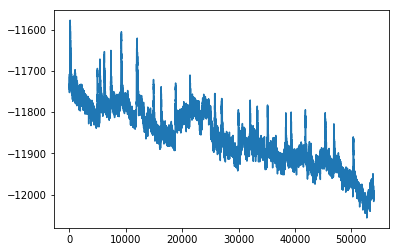

In [6]:
# plot raw data
plt.plot(X_arr_new[:, 9])
plt.show()

In [7]:
# Preprocessing
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y
def notch_filter(data, f0, fs, Q): # Q = Quality factor
    w0 = f0/(fs/2)
    b, a = iirnotch(w0, Q)
    y = filtfilt(b, a, data)
    return y
def preprocessing(data):
    """Preprocessing time-dimain EEG raw data

    Parameters
    ----------
    data : EEG time-domain raw data 

    Returns
    ----------
    filtered : filtered EEG time-domain raw data 
    """
    filtered = notch_filter(data, 50, smp_freq, 25)
    filtered = butter_bandpass_filter(filtered, 0.5, 49, smp_freq, 2) # Change from 1-40 Hz to 0.1-40Hz
    print('notch_filter 50 Hz .... banpass 1-40 Hz')
    return filtered

notch_filter 50 Hz .... banpass 1-40 Hz


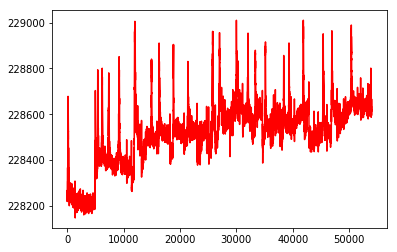

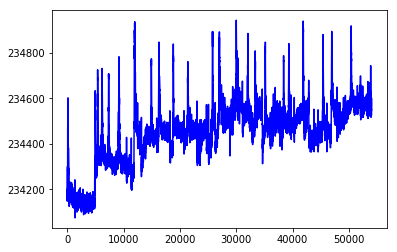

In [8]:
# plot raw data
X_filtered = preprocessing(X_arr_new)
plt.plot(X_filtered[:, 12], "r")
plt.show()
plt.plot(X_filtered[:, 15], "b")
plt.show()

In [9]:
X_swap = np.swapaxes(X_filtered, 0, 1)

In [10]:
def calulate_ICA(arr, save_name=None, threshold=2):
    """
    Parameters
    ----------
    arr : output from collect_data_allphase
    save_name : figure name, keep none if no need to save
    return:
        arr liked array with EOG removal
    """
    if save_name is not None:
        for directory in ['ica','eog_score','eog_avg','raw_EEG','corrected_EEG','montage','new_raw']:
            if not os.path.exists(directory):
                os.makedirs(directory)

    # Create a dummy mne.io.RawArray object
#     ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eog', 'eog']
    ch_names = ["AFz", "Fz", "Fp1", "Fp2", "AF7", "AF5", "AF3", "AF4", "AF6", "AF8", "F7", 
            "F5", "F3", "F1", "F2", "F4", "F6", "F8", "FT7", "FC5", "FC3", "FC1", "FCz", 
            "FC2", "FC4", "FC6", "FT8", "T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", 
            "T8","TP7", "CP5", "CP3", "CP1", "CPz", "CP2", "CP4", "CP6", "TP8", "P7", 
            "P5", "P3", "P1", "Pz", "P2", "P4", "P6", "P8", "PO7", "PO3", "POz", "PO4", 
            "PO8", "O1", "Oz", "O2"]
    ch_eogs = ["VEOG", "HEOG"]
    ch_names_all = ch_names+ch_eogs
    ch_types = ['eeg' for i in range(len(ch_names))] + ['eog', 'eog']
    # Create an info object.
    info = mne.create_info(ch_names=ch_names_all, sfreq=smp_freq, ch_types=ch_types)
    raw = mne.io.RawArray(arr, info)
    raw.set_montage("standard_1020")
    
    ica = ICA()
    ica.fit(raw)

    n_max_eog = 3  # use max 3 components
    eog_epochs = create_eog_epochs(raw)
    eog_epochs.decimate(5).apply_baseline((None, None))

    try:
        eog_inds, scores_eog = ica.find_bads_eog(eog_epochs,threshold=threshold)
        print('Found %d EOG component(s)' % (len(eog_inds),))

        #remove EOG from EEG
        ica.exclude += eog_inds
    except:
        pass
    raw_corrected = raw
    ica.apply(raw_corrected)
    print(ica)

    # #plot
    if save_name is not None:
        ica.plot_sources(raw, show = False).savefig('ica/'+save_name+'_ica.png') 
        try:
            ica.plot_scores(scores_eog, exclude=eog_inds, title='EOG scores',show = False).savefig('eog_score/'+save_name+'_eog_score.png') 
        except:
            pass
        scalings = 'auto'
        ica.plot_sources(eog_epochs.average(), title='EOG average',show = False).savefig('eog_avg/'+save_name+'_eog_avg.png')
        raw.plot(show = False,scalings=scalings).savefig('raw_EEG/'+save_name+'_raw_EEG.png')
        raw_corrected.plot(show = False,scalings=scalings).savefig('corrected_EEG/'+save_name+'_corrected_EEG.png')
        ica.plot_components(inst=raw, show = False)[0].savefig('montage/'+save_name+'_montage.png')
        print('======================================')
        print(raw_corrected.get_data().shape)
        raw_corrected.save('new_raw/'+save_name+'_raw.fif', overwrite=True)
    return raw_corrected

Creating RawArray with float64 data, n_channels=64, n_times=54000
    Range : 0 ... 53999 =      0.000 ...    44.999 secs
Ready.
Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 13.9s.
EOG channel index for this subject is: [62 63]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Filter length of 16384 samples (13.653 sec) selected


/Users/phairotautthasan/anaconda3/envs/mne/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Setting up band-pass filter from 2 - 45 Hz
Filter length of 16384 samples (13.653 sec) selected
Setting up band-pass filter from 1 - 10 Hz
Filter length of 16384 samples (13.653 sec) selected
Now detecting blinks and generating corresponding events
Number of EOG events detected : 25
25 matching events found
No baseline correction applied
Not setting metadata
Loading data for 25 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
Found 6 EOG component(s)
Transforming to ICA space (62 components)
Zeroing out 6 ICA components
<ICA  |  raw data decomposition, fit (fastica): 54000 samples, 62 components, channels used: "eeg", 6 sources marked for exclusion>


<ipython-input-10-42b340b6bf36>:36: RuntimeWarning: The measurement information indicates a low-pass frequency of 600 Hz. The decim=5 parameter will result in a sampling frequency of 240 Hz, which can cause aliasing artifacts.
  eog_epochs.decimate(5).apply_baseline((None, None))


(64, 54000)
Overwriting existing file.
Writing /Users/phairotautthasan/Documents/MUSEC/new_raw/s003_gtec_midi_01_093_raw.fif
Closing /Users/phairotautthasan/Documents/MUSEC/new_raw/s003_gtec_midi_01_093_raw.fif [done]


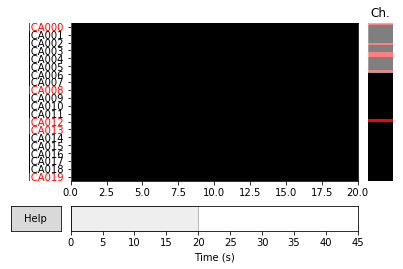

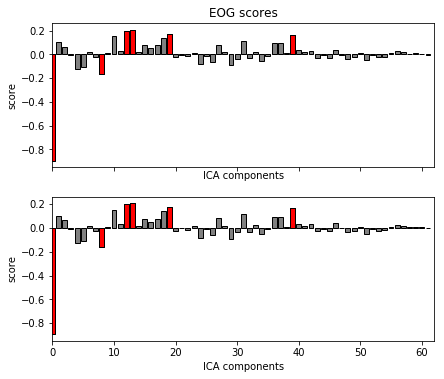

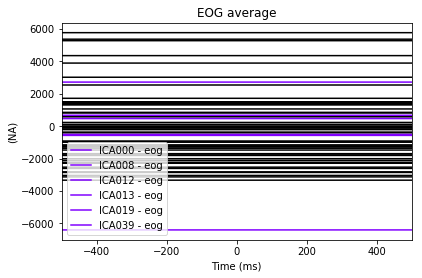

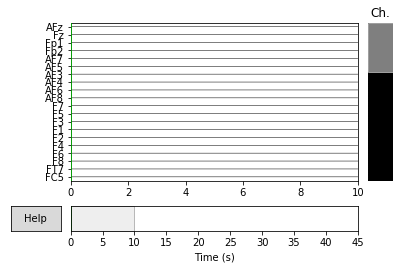

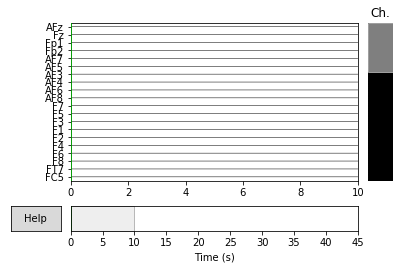

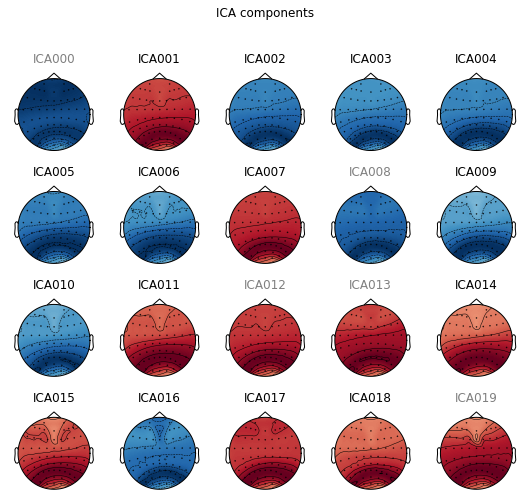

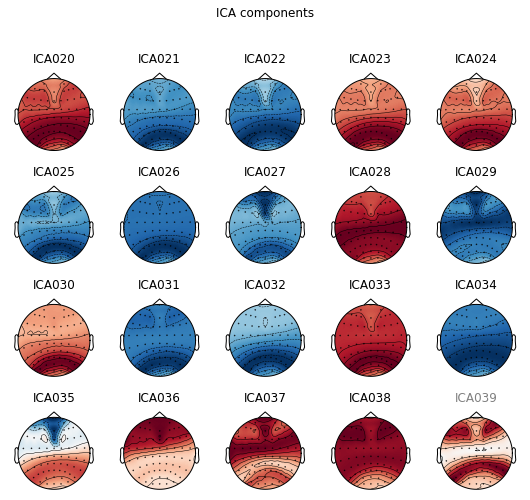

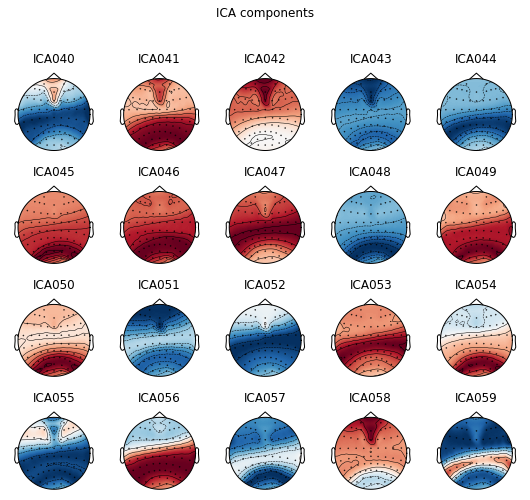

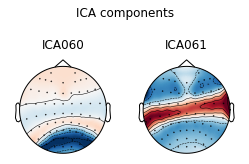

In [11]:
X_eog_removal = calulate_ICA(X_swap, save_name="s003_gtec_midi_01_093", threshold=2)

In [12]:
X_correct = X_eog_removal[:][0]

notch_filter 50 Hz .... banpass 1-40 Hz


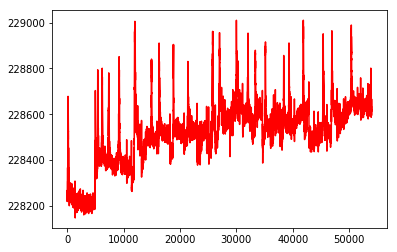

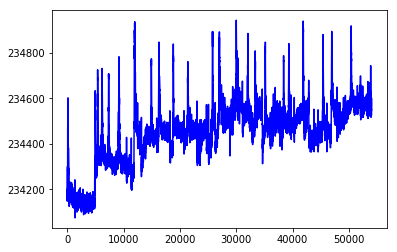

In [13]:
# plot raw data
X_filtered = preprocessing(X_arr_new)
plt.plot(X_filtered[:, 12], "r")
plt.show()
plt.plot(X_filtered[:, 15], "b")
plt.show()

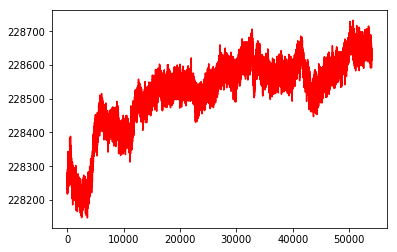

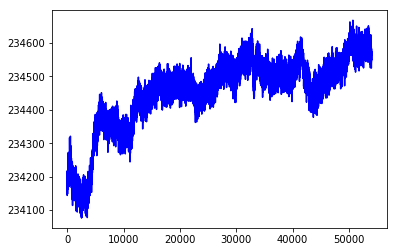

In [14]:
plt.plot(X_correct[12], 'r')
plt.show()
plt.plot(X_correct[15], 'b')
plt.show()

[[0 0 1]]
1 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 1 events and 53989 original time points ...
0 bad epochs dropped
Loading data for 1 events and 53989 original time points ...
Loading data for 1 events and 53989 original time points ...


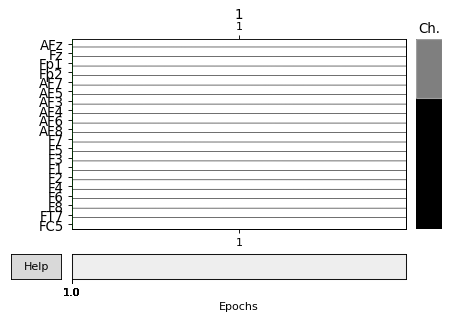

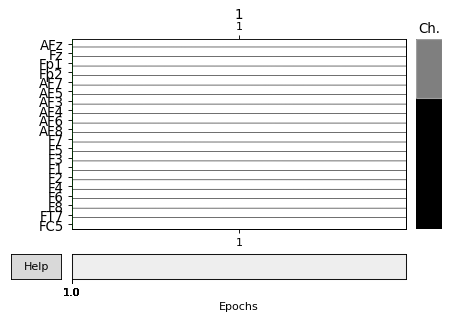

In [15]:
# The events are spaced evenly every 1 second.
duration = 45
event_id = 1
# create a fixed size events array
# start=0 and stop=None by default
events = mne.make_fixed_length_events(X_eog_removal, event_id, duration=duration)
print(events)

# for fixed size events no start time before and after event
tmin = 0.
tmax = 44.99 # inclusive tmax, 1 second epochs

# create :class:`Epochs <mne.Epochs>` object
epochs = mne.Epochs(X_eog_removal, events=events, event_id=event_id, tmin=tmin,
                    tmax=tmax, baseline=None, verbose=True)
epochs.plot(scalings='auto', block=True)

<ipython-input-16-62555f264b58>:3: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  evoked_no_ref.plot(titles=dict(eeg=title), time_unit='s')


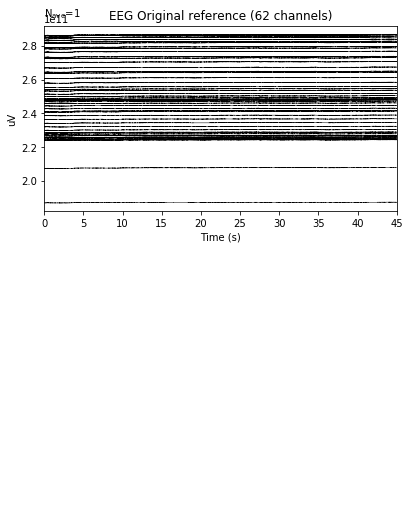

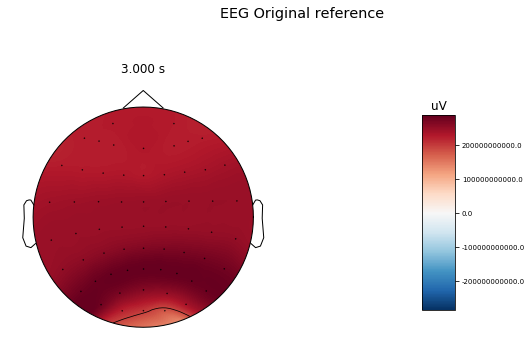

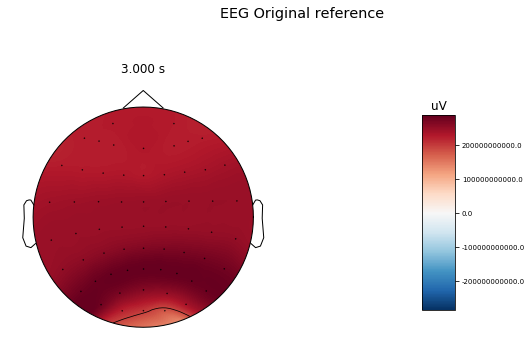

In [16]:
title = 'EEG Original reference'
evoked_no_ref = epochs.average()
evoked_no_ref.plot(titles=dict(eeg=title), time_unit='s')
evoked_no_ref.plot_topomap(times=[3], size=3, title=title, time_unit='s')

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
[[0 0 1]]
1 matching events found
No baseline correction applied
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated


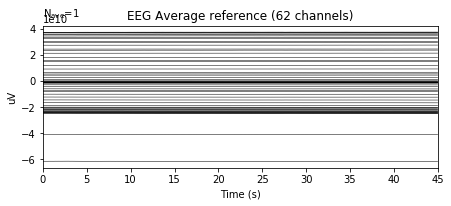

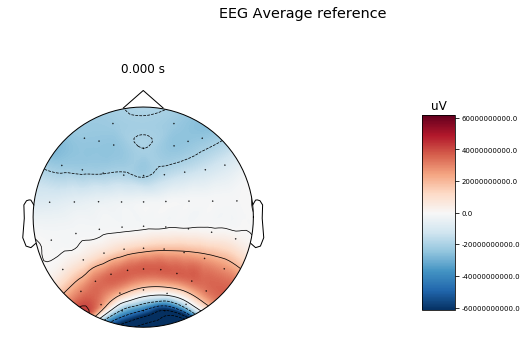

Loading data for 1 events and 53989 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


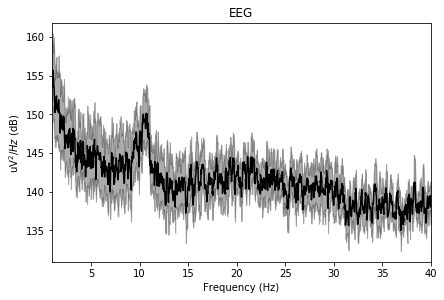

Loading data for 1 events and 53989 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


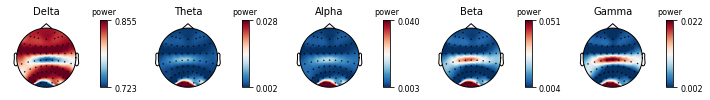

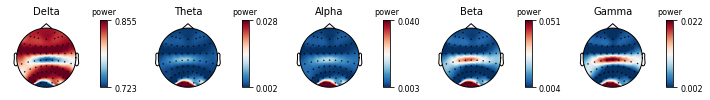

In [17]:
X_eog_removal.del_proj()
raw_car, _ = mne.set_eeg_reference(X_eog_removal, 'average', projection=True)
# The events are spaced evenly every 1 second.
duration = 45
event_id = 1
# create a fixed size events array
# start=0 and stop=None by default
events_car = mne.make_fixed_length_events(raw_car, event_id, duration=duration)
print(events)

# for fixed size events no start time before and after event
tmin = 0.
tmax = 44.99 # inclusive tmax, 1 second epochs

# create :class:`Epochs <mne.Epochs>` object
epochs_car = mne.Epochs(raw_car, events=events_car, event_id=event_id, tmin=tmin,
                    tmax=tmax, baseline=None, verbose=True)
epochs_car_avg = epochs_car.average()
title = 'EEG Average reference'
epochs_car_avg.plot(titles=dict(eeg=title), time_unit='s')
epochs_car_avg.plot_topomap(times=[0], size=3., title=title, time_unit='s')
epochs_car.plot_psd(fmin=1., fmax=40.)
epochs_car.plot_psd_topomap(ch_type='eeg', normalize=True)

Setting up band-pass filter from 8 - 31 Hz


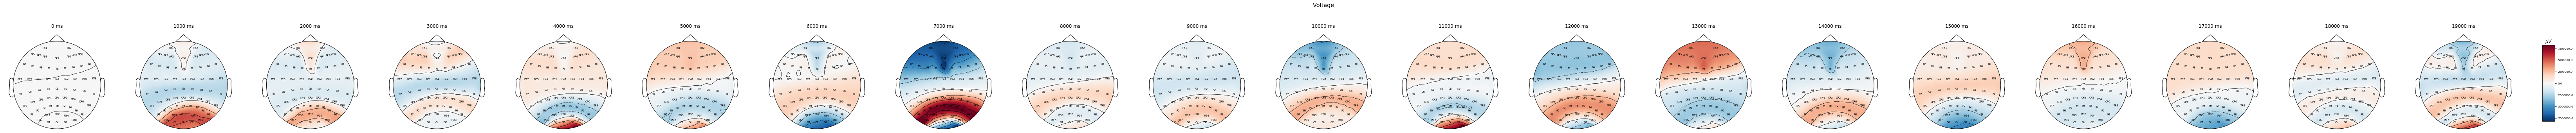

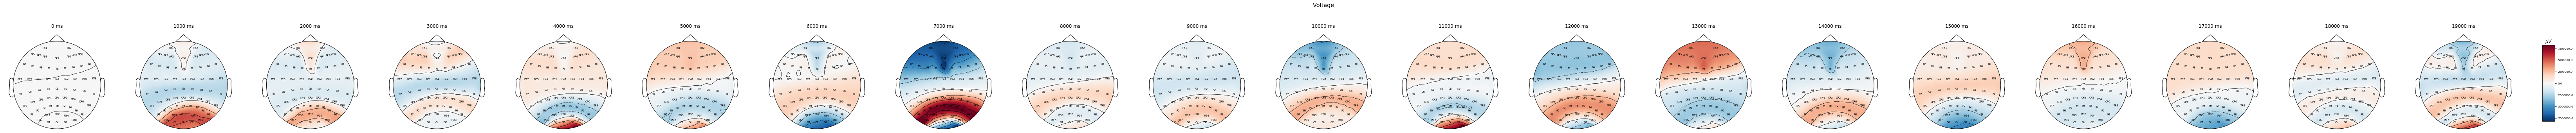

In [18]:
# Perform bandpass-filter for alphaband Theta(4-7 Hz), Alpha(8-15 Hz), Beta(8-31), Gamma (>32Hz), Mu (8-12 Hz.)

epochs_car_avg.filter(l_freq=8., h_freq=31., method="iir")
time_difine = np.arange(0, 20, 1)
# for t in time_difine:
#     epochs_car_avg.plot_topomap([t], ch_type='eeg', contours=6, show_names=True, size=(3), 
#                                 res=256, units="$\mu V$", time_unit='ms', 
#                                 cmap="RdBu_r", title="Voltage", scalings=dict(eeg=1e6))
epochs_car_avg.plot_topomap(time_difine, ch_type='eeg', contours=6, show_names=True, size=(3), 
                            res=256, units="$\mu V$", time_unit='ms', 
                            cmap="RdBu_r", title="Voltage", scalings=dict(eeg=1e6))

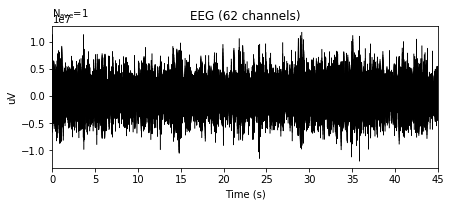

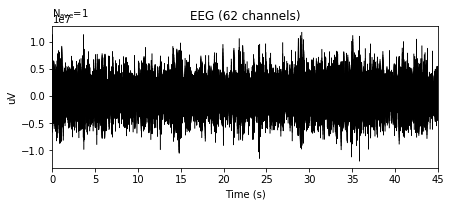

In [19]:
epochs_car_avg.plot()